<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Multimodal_Shap_Lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2920         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3572         49  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1653         39  1.0          

In [7]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# -----------------------------
# Load and preprocess image data
# -----------------------------
IMG_SIZE = 224
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: i for i, name in enumerate(classes)}

X_images, y_labels = [], []

def augment_image(img):
    img = cv2.flip(img, 1) if np.random.rand() < 0.5 else img
    return img

for class_name in classes:
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder): continue
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = augment_image(img)
        img = preprocess_input(img)
        X_images.append(img)
        y_labels.append(class_mapping[class_name])

X_images = np.array(X_images)
y_labels = to_categorical(y_labels, num_classes=len(classes))

# -----------------------------
# Load and preprocess tabular data
# -----------------------------
df = pd.read_csv("Ovarian_patient_data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
features = ['age', 'ca125', 'cancerstage', 'bmi']
df = df.dropna(subset=features).reset_index(drop=True)
df = df.iloc[:len(X_images)]  # Ensure alignment

scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[features].values)

# -----------------------------
# Train-test split
# -----------------------------
X_train_img, X_test_img, X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_images, X_tabular, y_labels, test_size=0.2, random_state=42
)

# -----------------------------
# Build multimodal model
# -----------------------------
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetV2B2(include_top=False, weights="imagenet", input_tensor=image_input, pooling="avg")
base_model.trainable = True
x = layers.Dense(256, activation="relu")(base_model.output)
x = layers.Dropout(0.4)(x)

# Tabular model - enhanced
tabular_input = Input(shape=(X_tabular.shape[1],), name="tabular_input")
y = layers.Dense(128, activation="relu")(tabular_input)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(64, activation="relu")(y)
y = layers.BatchNormalization()(y)
y = layers.Dense(32, activation="relu")(y)

# Combine
combined = layers.Concatenate()([x, y])
z = layers.Dense(256, activation='relu')(combined)
z = layers.Dropout(0.4)(z)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.3)(z)
output = layers.Dense(len(classes), activation='softmax')(z)

model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint("best_model_b2.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=25,
    batch_size=16,
    callbacks=[checkpoint, lr_reducer, early_stop]
)

# -----------------------------
# Evaluate
# -----------------------------
model.load_weights("best_model_b2.h5")
loss, acc = model.evaluate([X_test_img, X_test_tab], y_test)
print(f"\n✅ Best Accuracy with EfficientNetV2B2: {acc * 100:.2f}%")

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2502 - loss: 1.6321
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 263s 6s/step - accuracy: 0.2512 - loss: 1.6310 - val_accuracy: 0.4200 - val_loss: 1.5622 - learning_rate: 1.0000e-04
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2914 - loss: 1.5936
Epoch 2: val_accuracy improved from 0.42000 to 0.53000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step - accuracy: 0.2911 - loss: 1.5935 - val_accuracy: 0.5300 - val_loss: 1.4972 - learning_rate: 1.0000e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3463 - loss: 1.5139
Epoch 3: val_accuracy improved from 0.53000 to 0.59000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.3456 - loss: 1.5138 - val_accuracy: 0.5900 - val_loss: 1.4132 - learning_rate: 1.0000e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3995 - loss: 1.4386
Epoch 4: val_accuracy improved from 0.59000 to 0.68000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - accuracy: 0.4002 - loss: 1.4381 - val_accuracy: 0.6800 - val_loss: 1.3375 - learning_rate: 1.0000e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4767 - loss: 1.3441
Epoch 5: val_accuracy improved from 0.68000 to 0.73000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 205s 6s/step - accuracy: 0.4777 - loss: 1.3429 - val_accuracy: 0.7300 - val_loss: 1.2702 - learning_rate: 1.0000e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5274 - loss: 1.2821
Epoch 6: val_accuracy improved from 0.73000 to 0.81000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 168s 7s/step - accuracy: 0.5279 - loss: 1.2810 - val_accuracy: 0.8100 - val_loss: 1.1817 - learning_rate: 1.0000e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5529 - loss: 1.2129
Epoch 7: val_accuracy did not improve from 0.81000
25/25 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.5543 - loss: 1.2113 - val_accuracy: 0.7800 - val_loss: 1.1304 - learning_rate: 1.0000e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6237 - loss: 1.1169
Epoch 8: val_accuracy improved from 0.81000 to 0.82000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - accuracy: 0.6242 - loss: 1.1168 - val_accuracy: 0.8200 - val_loss: 1.0379 - learning_rate: 1.0000e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6715 - loss: 1.0770
Epoch 9: val_accuracy did not improve from 0.82000
25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.6717 - loss: 1.0756 - val_accuracy: 0.8100 - val_loss: 0.9450 - learning_rate: 1.0000e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7892 - loss: 0.9720
Epoch 10: val_accuracy did not improve from 0.82000
25/25 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.7886 - loss: 0.9718 - val_accuracy: 0.8200 - val_loss: 0.8613 - learning_rate: 1.0000e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7671 - loss: 0.8917
Epoch 11: val_accuracy improved from 0.82000 to 0.84000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.7688 - loss: 0.8896 - val_accuracy: 0.8400 - val_loss: 0.8083 - learning_rate: 1.0000e-04
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8534 - loss: 0.8057
Epoch 12: val_accuracy improved from 0.84000 to 0.85000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.8534 - loss: 0.8052 - val_accuracy: 0.8500 - val_loss: 0.7496 - learning_rate: 1.0000e-04
Epoch 13/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8866 - loss: 0.7050
Epoch 13: val_accuracy improved from 0.85000 to 0.86000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.8870 - loss: 0.7047 - val_accuracy: 0.8600 - val_loss: 0.7020 - learning_rate: 1.0000e-04
Epoch 14/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9470 - loss: 0.6151
Epoch 14: val_accuracy did not improve from 0.86000
25/25 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.9463 - loss: 0.6159 - val_accuracy: 0.8400 - val_loss: 0.7047 - learning_rate: 1.0000e-04
Epoch 15/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9539 - loss: 0.5871
Epoch 15: val_accuracy did not improve from 0.86000
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.9533 - loss: 0.5879 - val_accuracy: 0.8100 - val_loss: 0.6857 - learning_rate: 1.0000e-04
Epoch 16/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9171 - loss: 0.6360
Epoch 16: val_accuracy improved from 0.86000 to 0.87000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - accuracy: 0.9174 - loss: 0.6354 - val_accuracy: 0.8700 - val_loss: 0.6562 - learning_rate: 1.0000e-04
Epoch 17/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9541 - loss: 0.5691
Epoch 17: val_accuracy did not improve from 0.87000
25/25 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.9544 - loss: 0.5688 - val_accuracy: 0.8500 - val_loss: 0.6616 - learning_rate: 1.0000e-04
Epoch 18/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9858 - loss: 0.5354
Epoch 18: val_accuracy did not improve from 0.87000
25/25 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 0.9855 - loss: 0.5356 - val_accuracy: 0.8500 - val_loss: 0.6725 - learning_rate: 1.0000e-04
Epoch 19/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9664 - loss: 0.5317
Epoch 19: val_accuracy did not improve from 0.87000

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.9667 - loss: 0.5318 - val_ac

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step

Classification Report:
               precision    recall  f1-score   support

     Mucinous       0.96      0.81      0.88        27
Non_Cancerous       0.80      0.75      0.77        16
    Endometri       0.93      0.88      0.90        16
       Serous       0.89      1.00      0.94        16
   Clear_Cell       0.79      0.92      0.85        25

     accuracy                           0.87       100
    macro avg       0.87      0.87      0.87       100
 weighted avg       0.88      0.87      0.87       100



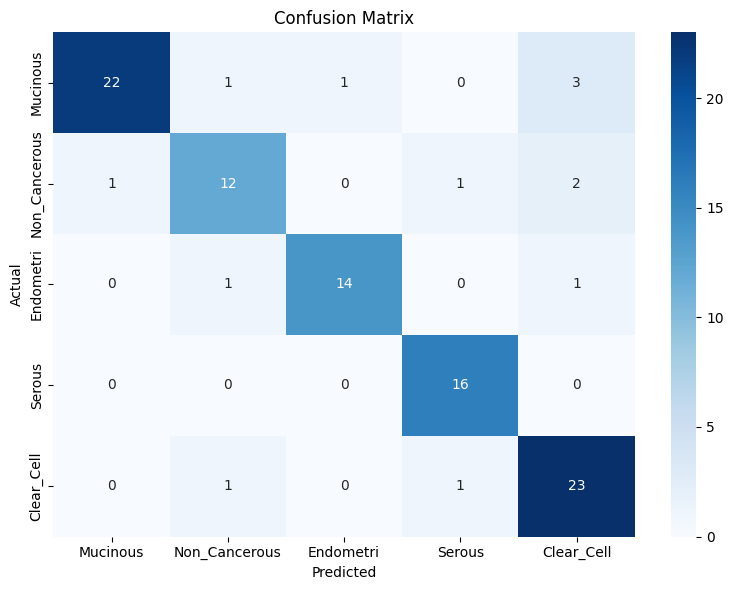

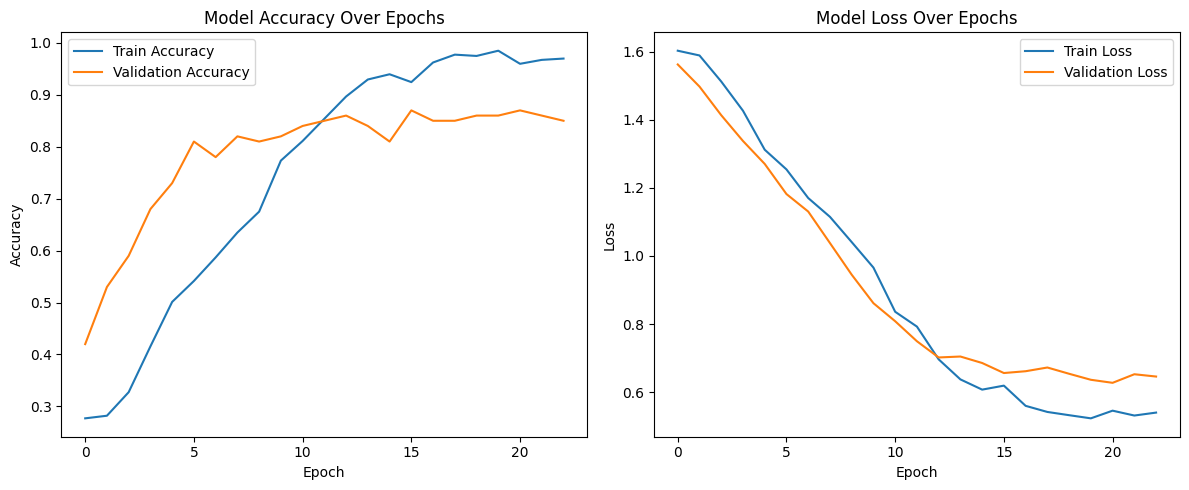

In [12]:
# -----------------------------
# Confusion Matrix & Classification Report
# -----------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model.predict([X_test_img, X_test_tab])
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# -----------------------------
# Accuracy and Loss Plots
# -----------------------------
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
!pip install lime shap scipy


In [ ]:
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Load dataset to get features
df = pd.read_csv("Ovarian_patient_data.csv")
# Selecting the same features used for training the model
features = ['age', 'ca125', 'cancerstage', 'bmi']  # This should match the features used in your model training
num_features = len(features)

# Confirm feature alignment with model input
assert X_test_tab.shape[1] == num_features, f"Data has {X_test_tab.shape[1]} features, CSV has {num_features}."

# Sample subset
num_samples = 5
X_tab_explain = X_test_tab[:num_samples]
X_img_explain = X_test_img[:num_samples]

# SHAP explanation
print("\n🧠 SHAP KernelExplainer for Class 0...")

def multimodal_predict_tab(data):
    img_batch = np.repeat(X_img_explain[:1], data.shape[0], axis=0)
    return model.predict([img_batch, data])

explainer = shap.KernelExplainer(multimodal_predict_tab, X_tab_explain)
shap_values = explainer.shap_values(X_tab_explain)

# SHAP bar plot for class 0
class_index = 0
shap_vals = shap_values[class_index]
mean_abs = np.abs(shap_vals).mean(axis=0)

# Sort feature importances
sorted_idx = np.argsort(mean_abs)[::-1]
# Ensure sorted_idx is within the range of features
sorted_idx = sorted_idx[sorted_idx < len(features)]  # Filter indices
sorted_features = [features[i] for i in sorted_idx]
sorted_importance = mean_abs[sorted_idx]


# Plot
print(f"\n📊 SHAP Bar Plot for Class 0 ({classes[class_index]})")
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_importance[::-1], color='mediumseagreen')
plt.xlabel("Mean |SHAP value|")
plt.title(f"SHAP Feature Importance - Class {classes[class_index]}")
plt.tight_layout()
plt.show()

# Top contributors
print("\n📌 Top 5 Contributing Features:")
for feat, val in zip(sorted_features[:5], sorted_importance[:5]):
    print(f"• {feat}: {val:.4f}")

# LIME explanation
print("\n🔍 LIME Explanation for Instance 0...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_tab,
    feature_names=features,
    class_names=classes,
    mode='classification'
)

lime_exp = lime_explainer.explain_instance(
    X_tab_explain[0],
    lambda x: model.predict([np.repeat(X_img_explain[0:1], x.shape[0], axis=0), x]),
    num_features=len(features)
)

lime_exp.show_in_notebook(show_table=True)

# T-test
print("\n🧪 T-Test on Class Probabilities...")
probs = model.predict([X_test_img, X_test_tab])
t_stat, p_val = ttest_ind(probs[:, 0], probs[:, 1])
print(f"T-test for '{classes[0]}' vs '{classes[1]}': T = {t_stat:.4f}, P = {p_val:.4e}")
print("✅ Significant difference" if p_val < 0.05 else "❌ Not significant")